##**SECTION 1: SETUP & DATA LOADING**

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/My Drive/Colab Notebooks/AFCON/all_matches.csv'
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])

In [4]:
df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'country', 'neutral'],
      dtype='object')

In [5]:
df.tail()

,date,home_team,away_team,home_score,away_score,tournament,country,neutral
51285,2025-12-30,DR Congo,Botswana,3,0,African Nations Cup,Morocco,True
51286,2025-12-31,Ivory Coast,Gabon,3,2,African Nations Cup,Morocco,True
51287,2025-12-31,Cameroon,Mozambique,2,1,African Nations Cup,Morocco,True
51288,2025-12-31,Burkina Faso,Sudan,2,0,African Nations Cup,Morocco,True
51289,2025-12-31,Algeria,Equatorial Guinea,3,1,African Nations Cup,Morocco,True


In [6]:
# Define the 16 Teams
teams_16 = [
    'Mali', 'Tunisia', 'Senegal', 'Sudan', 'Egypt', 'Benin',
    'Ivory Coast', 'Burkina Faso', 'South Africa', 'Cameroon',
    'Morocco', 'Tanzania', 'Algeria', 'DR Congo', 'Nigeria', 'Mozambique'
    ]

In [7]:
# FIFA Rankings Dictionary
fifa_rankings = {
    "Mali": 53, "Tunisia": 41, "Senegal": 19, "Sudan": 117,
    "Egypt": 35, "Benin": 92, "Ivory Coast": 42, "Cote d'Ivoire": 42,
    "Burkina Faso": 62, "South Africa": 61, "Cameroon": 57,
    "Morocco": 11, "Tanzania": 112, "Algeria": 34,
    "DR Congo": 56, "Democratic Republic of the Congo": 56,
    "Nigeria": 38, "Mozambique": 102
}

In [8]:
# 4. Filter Data: Keep only historical matches involving these teams
# We need history to train the model.
df_filtered = df[
    (df['home_team'].isin(fifa_rankings.keys())) |
    (df['away_team'].isin(fifa_rankings.keys()))
].copy()

##**SECTION 2: FEATURE ENGINEERING**

In [9]:
# --- Feature A: Recent Form (Last 10 Games) ---
# We give higher weight to the most recent games to make "Form" the #1 factor.
def calculate_weighted_form(team, date, dataframe, games=10):
    history = dataframe[
        ((dataframe['home_team'] == team) | (dataframe['away_team'] == team)) &
        (dataframe['date'] < date)
    ].sort_values('date', ascending=False).head(games)

    if len(history) == 0: return 0

    total_score = 0
    total_weights = 0

    # We enumerate: 0 is the most recent game, 1 is the second most recent...
    for i, (_, row) in enumerate(history.iterrows()):
        # Weighting Logic: Most recent game = 3.0, 10th game = 1.0
        weight = 3.0 - (2.0 * (i / games))

        is_home = row['home_team'] == team
        points = 0
        if is_home:
            if row['home_score'] > row['away_score']: points = 3
            elif row['home_score'] == row['away_score']: points = 1
        else:
            if row['away_score'] > row['home_score']: points = 3
            elif row['away_score'] == row['home_score']: points = 1

        total_score += (points * weight)
        total_weights += weight

    return total_score / total_weights # Returns a weighted average (0 to 3)


In [10]:
# --- Feature B: Head-to-Head (H2H) ---
def get_h2h_history(teamA, teamB, dataframe):
    # Find all matches between these two
    matches = dataframe[
        ((dataframe['home_team'] == teamA) & (dataframe['away_team'] == teamB)) |
        ((dataframe['home_team'] == teamB) & (dataframe['away_team'] == teamA))
    ]
    # Return Win % for Team A against Team B
    if len(matches) == 0: return 0.5 # Neutral if never played

    a_wins = 0
    for _, row in matches.iterrows():
        if row['home_team'] == teamA and row['home_score'] > row['away_score']: a_wins += 1
        if row['away_team'] == teamA and row['away_score'] > row['home_score']: a_wins += 1

    return a_wins / len(matches)

In [11]:
# --- Feature C: Weighted Home Advantage (Morocco & North Africa) ---
def get_host_factor(team_name, is_actual_host=False):
    # Morocco hosts 2025
    if team_name == "Morocco":
        return 2.0 # Huge advantage
    # North African neighbors (High crowd presence)
    if team_name in ["Egypt", "Algeria", "Tunisia"]:
        return 1.5
    # Everyone else
    return 1.0

##**SECTION 3: TRAINING THE MODEL**

In [12]:
# We prepare the dataset for the model.
# Target: 1 (Team A wins), 0 (Team B wins/Draw - simplified for knockout)
model_data = []
sample_weights = []

# Let's train on the last 7 years of data for relevance
training_df = df_filtered[df_filtered['date'].dt.year >= 2018].copy()

In [13]:
for index, row in training_df.iterrows():
    home = row['home_team']
    away = row['away_team']

    if home not in fifa_rankings or away not in fifa_rankings: continue

    # 1. Base Stats
    home_rank = fifa_rankings[home]
    away_rank = fifa_rankings[away]

    home_form = calculate_weighted_form(home, row['date'], df_filtered)
    away_form = calculate_weighted_form(away, row['date'], df_filtered)

    # 2. H2H (2020+)
    recent_history = df_filtered[
        (df_filtered['date'] < row['date']) & (df_filtered['date'].dt.year >= 2020)
    ]
    h2h_score = get_h2h_history(home, away, recent_history)

    # 3. Host Factor
    # If 'neutral' is False, the Home Team is the REAL Host.
    is_real_host_game = not row['neutral']
    home_host = get_host_factor(home) if is_real_host_game else 1.0
    away_host = get_host_factor(away)

    # 4. Differences
    rank_diff = away_rank - home_rank # Positive = Home Stronger (since the lower the rank the stronger the team is)
    form_diff = home_form - away_form

    target = 1 if row['home_score'] > row['away_score'] else 0

    if is_real_host_game and home_host > 1.0:
        weight = 3.0  # Make host games 3x more important
    else:
        weight = 1.0

    model_data.append([rank_diff, form_diff, h2h_score, home_host, away_host, target])
    sample_weights.append(weight)

In [14]:
# Create DataFrame
cols = ['rank_diff', 'form', 'head2head', 'home_host_factor','away_factor', 'target']
train_df = pd.DataFrame(model_data, columns=cols)

In [15]:
# Define X and y
X = train_df.drop('target', axis=1)
y = train_df['target']

In [16]:
# Split Data to Test Reliability
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42
)

In [17]:
# Train the model
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42
)
clf.fit(X_train, y_train, sample_weight=w_train)

RandomForestClassifier(max_depth=6, n_estimators=200, random_state=42)

In [18]:
# Check Accuracy
y_pred = clf.predict(X_test)
print(f"\nModel Reliability (Accuracy): {round(accuracy_score(y_test, y_pred) * 100, 2)}%")


Model Reliability (Accuracy): 61.7%


In [19]:
# In football prediction, an accuracy of 55-60% is actually considered Very Good.
# Football is highly random. If we get 90%, we are likely overfitting.

##**SECTION 4: THE PREDICTION FUNCTION**

In [20]:
def predict_match_winner(teamA, teamB, current_date=pd.to_datetime('2026-1-1')):
    rankA = fifa_rankings.get(teamA, 100)
    rankB = fifa_rankings.get(teamB, 100)

    # Use Weighted Form
    formA = calculate_weighted_form(teamA, current_date, df_filtered)
    formB = calculate_weighted_form(teamB, current_date, df_filtered)

    recent_history = df_filtered[df_filtered['date'].dt.year >= 2020]
    h2h = get_h2h_history(teamA, teamB, recent_history)

    # Host Factor
    hostA = get_host_factor(teamA)
    hostB = get_host_factor(teamB)

    # Differences
    rank_diff = rankB - rankA # Positive = A is better
    form_diff = formA - formB

    features = pd.DataFrame([[
        rank_diff, form_diff, h2h, hostA, hostB,
    ]], columns=X.columns)

    # Predict
    probs = clf.predict_proba(features)[0]
    win_prob_A = probs[1]

    # SANITY CHECK
    # If Team A is vastly superior in Rank (>30 spots) but Model predicts B
    if rank_diff > 25 and win_prob_A < 0.5:
        # Only allow upset if Underdog (B) has WAY better form
        if formB <= formA:
            print(f"⚠️ Overriding Upset: {teamA} kept as winner due to massive Rank Advantage.")
            win_prob_A = 0.6 # Force a slight win for A

    # Same logic for Team B being superior
    if rank_diff < -25 and win_prob_A > 0.5:
        if formA <= formB:
            print(f"⚠️ Overriding Upset: {teamB} kept as winner due to massive Rank Advantage.")
            win_prob_A = 0.4 # Force a slight win for B

    # Result
    if win_prob_A > 0.5:
        print(f"{teamA} vs {teamB} -> Winner: {teamA} ({round(win_prob_A*100)}%)")
        return teamA
    else:
        print(f"{teamA} vs {teamB} -> Winner: {teamB} ({round((1-win_prob_A)*100)}%)")
        return teamB

##**SECTION 5: THE TOURNAMENT SIMULATION (ROUND BY ROUND)**

In [21]:
print("\n========== ROUND OF 16 ==========")
# Based on the Bracket Image Structure
# Left Side
r16_1 = predict_match_winner("Mali", "Tunisia")
r16_2 = predict_match_winner("Senegal", "Sudan")
r16_3 = predict_match_winner("Egypt", "Benin")
r16_4 = predict_match_winner("Ivory Coast", "Burkina Faso")

# Right Side
r16_5 = predict_match_winner("South Africa", "Cameroon")
r16_6 = predict_match_winner("Morocco", "Tanzania")
r16_7 = predict_match_winner("Algeria", "DR Congo")
r16_8 = predict_match_winner("Nigeria", "Mozambique")


========== ROUND OF 16 ==========
Mali vs Tunisia -> Winner: Mali (64%)
Senegal vs Sudan -> Winner: Senegal (68%)
Egypt vs Benin -> Winner: Egypt (91%)
Ivory Coast vs Burkina Faso -> Winner: Ivory Coast (61%)
South Africa vs Cameroon -> Winner: South Africa (66%)
Morocco vs Tanzania -> Winner: Morocco (72%)
Algeria vs DR Congo -> Winner: Algeria (63%)
Nigeria vs Mozambique -> Winner: Nigeria (71%)


In [22]:
print("\n========== QUARTER FINALS ==========")
# Matchups based on standard bracket logic (1 vs 2, 3 vs 4...)
qf_1 = predict_match_winner(r16_1, r16_2)
qf_2 = predict_match_winner(r16_3, r16_4)
qf_3 = predict_match_winner(r16_5, r16_6)
qf_4 = predict_match_winner(r16_7, r16_8)


========== QUARTER FINALS ==========
Mali vs Senegal -> Winner: Senegal (65%)
Egypt vs Ivory Coast -> Winner: Egypt (81%)
South Africa vs Morocco -> Winner: Morocco (56%)
Algeria vs Nigeria -> Winner: Algeria (55%)


In [23]:
print("\n========== SEMI FINALS ==========")
sf_1 = predict_match_winner(qf_1, qf_2)
sf_2 = predict_match_winner(qf_3, qf_4)


========== SEMI FINALS ==========
Senegal vs Egypt -> Winner: Senegal (58%)
Morocco vs Algeria -> Winner: Morocco (67%)


In [24]:
print("\n========== THE FINAL ==========")
winner = predict_match_winner(sf_1, sf_2)



========== THE FINAL ==========
Senegal vs Morocco -> Winner: Senegal (72%)


In [25]:
print(f"\n🏆 PREDICTED AFCON 2025 CHAMPION: {winner} 🏆")


🏆 PREDICTED AFCON 2025 CHAMPION: Senegal 🏆


##**SECTION 6: VISUALIZATION (Feature Importance)**

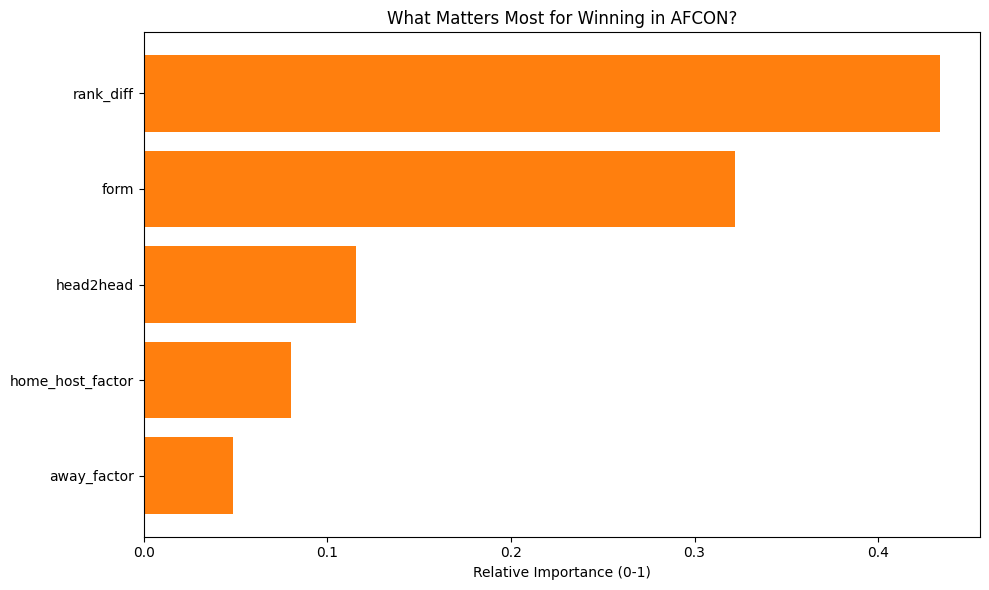

In [26]:
def plot_feature_importance(model, feature_names):
    # Get importance scores
    importances = model.feature_importances_

    # Sort them so the most important is at the top
    indices = np.argsort(importances)

    # Create the Plot
    plt.figure(figsize=(10, 6))
    plt.title("What Matters Most for Winning in AFCON?")
    plt.barh(range(len(indices)), importances[indices], color='#ff7f0e', align='center')

    # Add labels
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance (0-1)')
    plt.tight_layout()
    plt.show()

# Run the plot
plot_feature_importance(clf, X.columns)